In [58]:
import os
import numpy as np
import datajoint as dj
import spyglass as nd

import matplotlib.pyplot as plt
# ignore datajoint+jupyter async warnings
import warnings
warnings.simplefilter('ignore', category=DeprecationWarning)
warnings.simplefilter('ignore', category=ResourceWarning)

from spyglass.common import (Session, IntervalList,LabMember, LabTeam, Raw, Session, Nwbfile,
                            Electrode)
import spyglass.spikesorting as ss
from spyglass.spikesorting import (SortGroup, 
                                    SortInterval,
                                    SpikeSortingPreprocessingParameters,
                                    SpikeSortingRecording, 
                                    SpikeSorterParameters,
                                    SpikeSortingRecordingSelection,
                                    ArtifactDetectionParameters, ArtifactDetectionSelection,
                                    ArtifactRemovedIntervalList, ArtifactDetection,
                                      SpikeSortingSelection, SpikeSorting,)
import spikeinterface as si

import scipy.stats as stats

# (SpikeSortingRecording() & {'team_name': 'ac_em_xs'} &{'sort_interval_name':'02_r1_noPrePostTrialTimes_test_100s'})


# wilbur20210406_.nwb
# 25

In [59]:
# sort_group = 25
# nwb_file_name='chimi20200216_new_.nwb'
# # sort_interval_name = 'sleeps_runs_noPrePostTrialTimes raw data valid times'
# sort_interval_name = '04_r2noPrePostTrialTimes_test_100s'

nwb_file_name='wilbur20210406_.nwb'
sort_interval_name = '02_r1_noPrePostTrialTimes_test_100s'
sort_group= 25
# # sort_interval_name = 'runs_noPrePostTrialTimes raw data valid times'
electrode_wire_to_view = 0

#go to artifact detection table to find the params associated with this file,check if theres more than one
artifact_param_ix = 1
artifact_params = (ArtifactDetectionSelection &  {'nwb_file_name' : nwb_file_name} & {'sort_group_id':sort_group}).fetch('artifact_params_name')
print(artifact_params)
# change the zero if you want other artifact params than the first one, based on printout of artifact params
artifact_params = artifact_params[artifact_param_ix]
print(artifact_params)
look_at_raw = True
look_at_hists = False
look_at_1_elec_art = True
look_at_all_art_all_elecs = False
look_at_all_raw_with_art = False



#just use 1, load it, and then delete? google how to delete a variable 

['default' 'z_5_prop_025_1ms']
z_5_prop_025_1ms


In [3]:
#start scratch- this is to quickly popualte artifact tables with new params 

In [4]:
# (SpikeSortingRecordingSelection() & {'nwb_file_name':nwb_file_name} & {'sort_group_id':30})#.fetch('sort_group_id')

In [5]:

# artifact_param_names =  'ampl_1000_prop_075_1ms'
# artifact_key = (SpikeSortingRecordingSelection() &  {'nwb_file_name' : nwb_file_name} & 
#                  {'sort_interval_name' : sort_interval_name} & {'sort_group_id' : sort_group}).fetch1('KEY')
# artifact_key['artifact_params_name'] = artifact_param_names

# ArtifactDetectionSelection.insert1(artifact_key, skip_duplicates=True)



In [6]:
# ArtifactDetectionSelection & artifact_key

In [7]:
# ArtifactDetection.populate([(ArtifactDetectionSelection & artifact_key).proj()])

In [8]:
# (ArtifactDetection & artifact_key).fetch('artifact_times')

In [9]:
#end scratch

In [72]:
# %%timeit
#this cell will get the recording path, grab the recording, get valid timestamps and data from this recording. At least for the plots. 
# sclicing in numpy, not as list. 

recording_path = (SpikeSortingRecording & {'nwb_file_name' : nwb_file_name} & {'sort_interval_name' :sort_interval_name} & {'sort_group_id' : sort_group}).fetch1('recording_path')

recording = si.load_extractor(recording_path)
valid_timestamps = SpikeSortingRecording._get_recording_timestamps(recording)
if recording.get_num_segments() > 1 and isinstance(recording, si.AppendSegmentRecording):
    recording = si.concatenate_recordings(recording.recording_list)
elif recording.get_num_segments() > 1 and isinstance(recording, si.BinaryRecordingExtractor):
    recording = si.concatenate_recordings([recording])
data = recording.get_traces()

#reinforcement learning, sutton, barto - free online. first chapter

#any if people have found a good way to characterize 
#ask daniel and jen
#post publicaly. 


Versions are not the same. This might lead to errors. Use  spikeinterface version 0.95.0.dev0


In [73]:
data.shape

(2999974, 32)

In [44]:
data = np.asarray(recording.get_traces()) #- can take every 5th data point or something. 6 data points per ms 

data

array([[ 3,  3, -1, ...,  0,  1, -1],
       [ 7, 31, 25, ...,  6,  5, 10],
       [12, 41, 27, ...,  8, 13, 16],
       ...,
       [ 7,  5, 17, ..., 11,  6,  6],
       [-6, -6, 15, ...,  4,  8, -4],
       [-5, -2,  2, ..., -3,  0, -1]], dtype=int16)

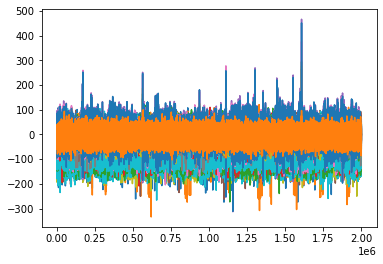

In [45]:
for ix in range(0,32):
    plt.plot(data[:,ix])

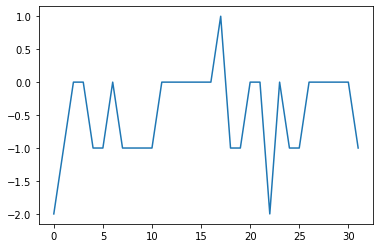

In [6]:
data.shape

(2999974, 32)

In [74]:
artifact_params = 'z_5_prop_025_1ms'

In [75]:
(ArtifactDetectionParameters() & {'artifact_params_name':artifact_params}).fetch1('artifact_params')

{'zscore_thresh': 5,
 'amplitude_thresh': None,
 'proportion_above_thresh': 0.25,
 'removal_window_ms': 1}

In [76]:
amplitude_thresh =  (ArtifactDetectionParameters() & {'artifact_params_name':artifact_params}).fetch1('artifact_params')['amplitude_thresh']
zscore_thresh = (ArtifactDetectionParameters() & {'artifact_params_name':artifact_params}).fetch1('artifact_params')['zscore_thresh']
proportion_above_thresh = (ArtifactDetectionParameters() & {'artifact_params_name':artifact_params}).fetch1('artifact_params')['proportion_above_thresh']

In [143]:
zscore_thresh
amplitude_thresh
nelect_above=np.ceil(.75 *
                           len(recording.get_channel_ids()))

In [147]:
nelect_above

24.0

In [145]:
if ((amplitude_thresh is None) and (zscore_thresh is not None)):
        dataz = np.abs(stats.zscore(data, axis=0))
        above_z = dataz[:,] > zscore_thresh
        above_thresh = np.ravel(np.argwhere(
            np.sum(above_z, axis=1) >= nelect_above))

In [148]:
above_thresh

array([   2365,    2366,    2367,   15984,   20200,   20201,   20202,
         20203,   20206,   20207,   20208,   35357,   35358,   35359,
         77309,   77317,   77318,  163728,  163729,  163730,  163731,
        163732,  163733,  258447,  258448,  258449,  258450,  258451,
        333966,  333967,  333968,  333969,  333970,  333971,  333972,
        333973,  333974,  333985,  333986,  333987,  333988,  333989,
        344948,  389072,  389073,  389074,  389075,  389076,  389096,
        389097,  389098,  389099,  511717,  511718,  511719,  526369,
        526370,  526371,  526372,  526373,  526374,  526375,  526376,
        526377,  591658,  591659,  591660,  591661,  596262,  596263,
        601146,  631389,  631390,  631391,  631392,  631393,  691379,
        691392,  691393,  691394,  691395,  691396,  720160,  720161,
        720162,  720163,  737146,  737147,  737148,  819466,  819467,
        819468,  819469,  819470,  819471,  863376,  863377,  863378,
        863379,  863

In [53]:
data_sample = dataz[:,1]

In [31]:
data_sample.shape

(2999974,)

In [ ]:
for ix in range(0,32):
    plt.figure()
    data_sample = dataz[:,ix]
    plt.plot(data_sample >5)
plt.title('finding when the data is over 5- diff colors = diff electrodes')

In [61]:
1617726933.1902506 in valid_timestamps



True

In [79]:
for ix in range(0,32):
    plt.plot(data[[valid_timestamps==1617726933.1902506],ix])

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [88]:
for ix in range(0,32):
    print(dataz[:,ix][valid_timestamps==1617726933.1902175])

[1.67644465]
[0.36586903]
[0.11467537]
[0.50784805]
[0.40955488]
[0.23481147]
[0.32218317]
[0.36586903]
[0.93378513]
[0.49692659]
[0.93378513]
[0.62798415]
[0.42047635]
[0.4641622]
[1.89487392]
[0.14743976]
[0.81364903]
[0.98839245]
[1.19590026]
[0.68259147]
[0.20204708]
[0.24573293]
[2.89964857]
[0.50784805]
[0.0163822]
[1.33787928]
[1.20682172]
[1.73105197]
[1.38156514]
[1.0320783]
[0.55153391]
[0.33310464]


In [71]:
# dataz.shape
valid_timestamps.shape

(2999974,)

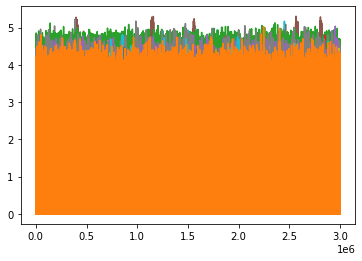

In [95]:
dataz = np.abs(stats.zscore(data, axis=1))
for ix in range(0,32):
    # plt.figure()
    plt.plot(dataz[:,ix])
    

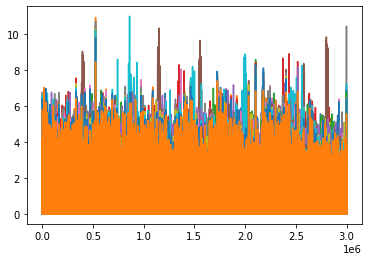

In [98]:
for ix in range(0,32):
    dataz = np.abs(stats.zscore(data[:,ix]))
    plt.plot(dataz)

(2999974,)

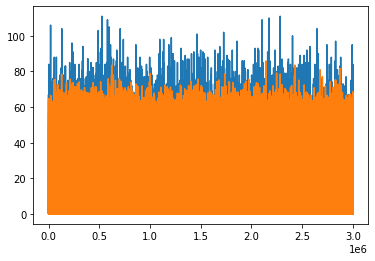

In [110]:
plt.plot(abs(data[:,0]))
# plt.figure()
plt.plot(22*dataz[:,0])

KeyboardInterrupt: 

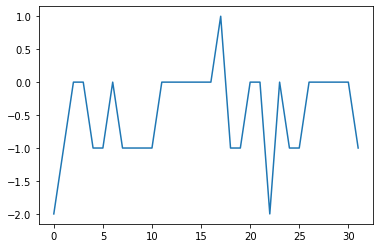

In [111]:
plt.plot(data[0,:])
plt.plot(dataz[:,0])

In [107]:
dataz = np.abs(stats.zscore(data, axis=1))


In [96]:
data.shape

(2999974, 32)

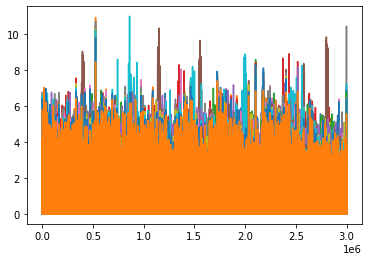

In [99]:
dataz = np.abs(stats.zscore(data, axis=0))
for ix in range(0,32):
    # plt.figure()
    plt.plot(dataz[:,ix])

In [ ]:
data

In [115]:
data_eg = np.asarray([[5,15,30],[1,2,3],[0,10,5],[10,30,45]])


# print(data_eg.shape)

# data_1 = stats.zscore([5,15,30])
# print(data_1)

# # data_2 = stats.zscore([1,2,3])
# # print(data_2)

# # data_3 = stats.zscore([0,10,5])
# # print(data_3)

# data_4 = stats.zscore([10,30,45])
# print(data_4)

axis_0 = stats.zscore(data_eg,axis = 0)
print(axis_0)
axis_1 = stats.zscore(data_eg,axis = 1)
print(axis_1)


[[ 0.25400025  0.07347734  0.52605453]
 [-0.76200076 -1.20012997 -1.009456  ]
 [-1.01600102 -0.41637162 -0.89571448]
 [ 1.52400152  1.54302424  1.37911594]]
[[-1.13554995 -0.16222142  1.29777137]
 [-1.22474487  0.          1.22474487]
 [-1.22474487  1.22474487  0.        ]
 [-1.27872403  0.11624764  1.16247639]]


In [130]:
print(f'shape of original data set = {data.shape}\n we want to take zscore within 1 electrode, over time')


shape of original data set = (2999974, 32)
 we want to take zscore within 1 electrode, over time


In [132]:
# data_eg = np.array([[0,0,0,0,0,0,0],[2,2,2,2,2,2,2]])
data_eg = np.array([[0,0],[1,1],[4,6],[8,10],[20,50]])
print(f'example data set, where relative dimensions match the original-{data_eg.shape}')

example data set, where relative dimensions match the original-(5, 2)


In [133]:
axis_0 = stats.zscore(data_eg,axis = 0)
print(f'axis = 0 results in {axis_0}')
axis_1 = stats.zscore(data_eg,axis = 1)
print(f'axis = 1 results in {axis_1}')

axis = 0 results in [[-0.90967445 -0.71848059]
 [-0.77184498 -0.66486263]
 [-0.3583566  -0.39677286]
 [ 0.19296125 -0.18230104]
 [ 1.84691479  1.96241712]]
axis = 1 results in [[nan nan]
 [nan nan]
 [-1.  1.]
 [-1.  1.]
 [-1.  1.]]


In [139]:
print (f'now if i manually take the entries down one column, which is the longer, time axis I get \nstats.zscore([0,1,4,8,20]) = {stats.zscore([0,1,4,8,20])}\n which matches axis = 0. this is what we want')


now if i manually take the entries down one column, which is the longer, time axis I get 
stats.zscore([0,1,4,8,20]) = [-0.90967445 -0.77184498 -0.3583566   0.19296125  1.84691479]
 which matches axis = 0. this is what we want


In [138]:


print (f'now if i muanlly take the entries within a row, which is the shorter (x electrodes), I get \nstats.zscore([0,0])={stats.zscore([0,0])}\n which matches axis = 1')



now if i muanlly take the entries within a row, which is the shorter (x electrodes), I get 
stats.zscore([0,0])=[nan nan]
 which matches axis = 1


In [149]:
stats.describe(data, axis=0)

DescribeResult(nobs=2999974, minmax=(array([-111, -143, -157, -161, -161, -156, -154, -161, -162, -155, -145,
       -140, -162, -163, -124, -168, -173, -175, -116, -157, -177, -181,
       -181, -172, -171, -175, -180, -210, -173, -193, -164, -162],
      dtype=int16), array([110, 126, 130, 132, 115, 125, 133, 129, 121, 123, 119, 118, 138,
       138, 130, 123, 134, 138, 118, 131, 129, 135, 162, 143, 125, 137,
       138, 149, 138, 135, 139, 133], dtype=int16)), mean=array([-0.00570105, -0.00158235, -0.00070634, -0.00096334, -0.00172235,
       -0.00125134, -0.00103101, -0.00137335, -0.00121401, -0.00119468,
       -0.00290003, -0.00214335, -0.00188802, -0.00265002, -0.00388003,
       -0.00145468, -0.00043634, -0.00099534, -0.00611039, -0.00138668,
       -0.000365  , -0.00061501, -0.01098176, -0.00106901, -0.0043807 ,
       -0.00225302, -0.00069767, -0.00131401, -0.00093867, -0.00055734,
       -0.00141168, -0.00029767]), variance=array([291.20532735, 238.77628682, 247.36690414, 28

In [150]:
stats.describe(data, axis=1)

DescribeResult(nobs=32, minmax=(array([ -2, -14, -17, ..., -42, -29,   0], dtype=int16), array([ 1, 10, 16, ..., -7, -5,  6], dtype=int16)), mean=array([ -0.46875,  -2.375  ,  -1.375  , ..., -24.21875, -16.0625 ,
         2.0625 ]), variance=array([ 0.45060484, 18.69354839, 42.17741935, ..., 88.24092742,
       41.15725806,  2.31854839]), skewness=array([-0.43997014, -0.13153526, -0.08009067, ...,  0.02611507,
       -0.03609158,  0.8959955 ]), kurtosis=array([-0.14224584,  1.69545017,  0.72794007, ..., -0.99292181,
       -0.79869797,  0.70536106]))